# Visualization of averaged sample plane flow fields

Note: you can run this notebook at the command line with:
```bash 
jupyter nbconvert --to notebook --execute MakePlots.ipynb --output MakePlots
```

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

import postproamrwindsample_xarray as ppsamplexr
import numpy as np
import pprint
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Load ruamel or pyyaml as needed
try:
    import ruamel.yaml
    import ruamel.yaml as yaml
    yaml = ruamel.yaml.YAML(typ='unsafe', pure=True)
    useruamel=True
    loaderkwargs = {'Loader':yaml.RoundTripLoader}
    dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':4, 'default_flow_style':False}
    Loader=yaml.load
except:
    import yaml as yaml
    useruamel=False
    loaderkwargs = {}
    dumperkwargs = {'default_flow_style':False }
    Loader=yaml.safe_load


In [3]:
# Load the inputs to visualize
yamlfile  = 'postpro.yaml'
verbose   = True

with open(yamlfile, 'r') as fp:
    yamldict = Loader(fp, **loaderkwargs)

In [4]:
if verbose:
    print(yaml.dump(yamldict['avgplanes'], default_flow_style=False))

- name: coarse XY plane
  ncfile:
  - ../MedWS_LowTI_4kmx2km_5m/post_processing/XYdomaincoarse_68125.nc
  - ../MedWS_LowTI_4kmx2km_5m/post_processing/XYdomaincoarse_103125.nc
  plot:
    clevels: np.linspace(0, 12, 121)
    iplane: 0
    plotfunc: 'lambda u, v, w: np.sqrt(u**2 + v**2)'
    savefile: avgXYdomaincoarse.png
    title: XY Horizontal velocity
    xaxis: x
    xlabel: X [m]
    yaxis: y
    ylabel: Y [m]
  savepklfile: test.pkl
  tavg:
  - 27000
  - 29000



coarse XY plane
../MedWS_LowTI_4kmx2km_5m/post_processing/XYdomaincoarse_68125.nc 1522
[============================================================] 100.0% 
../MedWS_LowTI_4kmx2km_5m/post_processing/XYdomaincoarse_103125.nc 880
[============================================================] 99.9% 
Ncount = 2401



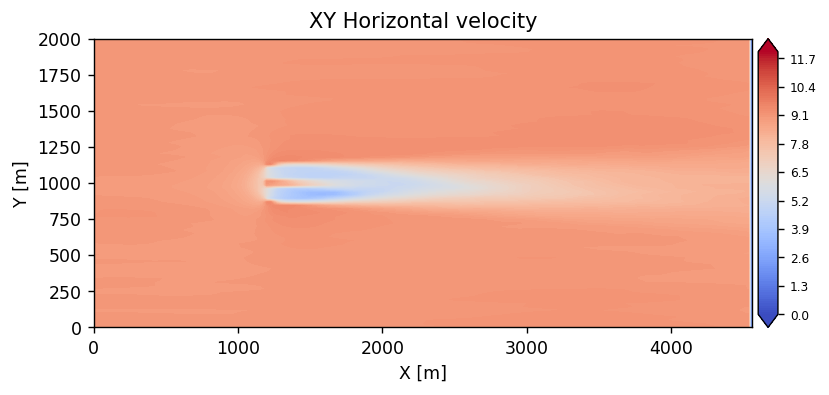

In [5]:
getdictval = lambda dict, key, default: dict[key] if key in dict else default

## Look at the average planes
for plane in yamldict['avgplanes']:
    print(plane['name'])
    tavg     = plane['tavg']
    ncfile   = plane['ncfile']

    # Load optional quantities
    group    = getdictval(plane, 'group', None)
    varnames = getdictval(plane, 'varnames', ['velocityx', 'velocityy', 'velocityz'])
    pklfile  = getdictval(plane, 'group', '')
    #print(tavg)
    #print(ncfile)

    # Load the plane
    dbavg  = ppsamplexr.avgPlaneXR(ncfile, tavg, varnames=varnames, groupname=group, savepklfile=pklfile, verbose=verbose)

    if 'plot' in plane:
        plotplane = plane['plot']
        iplane   = plotplane['iplane']
        xaxis    = plotplane['xaxis']
        yaxis    = plotplane['yaxis']
        # Optional
        plotfunc = eval(getdictval(plotplane, 'plotfunc', lambda u, v, w: np.sqrt(u**2 + v**2)))
        title    = getdictval(plotplane, 'title', f'AVG')
        clevels  = eval(getdictval(plotplane, 'clevels', 41))
        xlabel   = getdictval(plotplane, 'xlabel', xaxis)
        ylabel   = getdictval(plotplane, 'ylabel', yaxis)
        savefile = getdictval(plotplane, 'savefile', '')

        plotq = plotfunc(dbavg['velocityx_avg'], dbavg['velocityy_avg'], dbavg['velocityz_avg'])
        fig, ax = plt.subplots(1,1,figsize=(12,3), dpi=125)
        c=plt.contourf(dbavg[xaxis][iplane,:,:], 
                       dbavg[yaxis][iplane,:,:], plotq[iplane, :, :], 
                       levels=clevels, cmap='coolwarm', extend='both')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        cbar=fig.colorbar(c, ax=ax, cax=cax)
        cbar.ax.tick_params(labelsize=7)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(eval("f'{}'".format(title)))
        ax.axis('scaled')
        if len(savefile)>0: plt.savefig(savefile)